# Aplicação do algoritmo

In [1]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from timeseriesmetrics import *

models_label = []
models_MAPE = []
models_MAE = []
models_R2 = []
models_theil = []


def computeAccuracyModels(models, y_pred,y_true):
    # Agora iteramos sobre o nome dos modelos
    models_label.append(models)
    
    # Previsões extraídas da coluna especificada no DataFrame
    y_pred = y_pred.values  # Pegando a coluna de previsões
    
    # Tratamento de NaN: Remover os dois primeiros valores (caso sejam NaN)
    y_pred_clean = y_pred
    y_true_clean = y_true.values.ravel() 

    
    # Cálculo das métricas de erro usando os valores sem os primeiros dois NaN
    models_MAE.append(mean_absolute_error(y_true=y_true_clean, y_pred=y_pred_clean))
    models_MAPE.append(mean_absolute_percentage_error(y_true=y_true_clean, y_pred=y_pred_clean))
    models_R2.append(r2_score(y_true=y_true_clean, y_pred=y_pred_clean))
    models_theil.append(theil(y_true_clean,y_pred))

    # Criação do DataFrame com os resultados
    df = pd.DataFrame({
        'model': models_label, 
        'MAE': models_MAE,
        'MAPE': models_MAPE,
        'R2': models_R2,
        'theil': models_theil
    })
    
    print(" --------------------------- Medidas de Erro para os Modelos  --------------------------- ") 
    print(df.sort_values(by='MAE', ascending=True))


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [3]:
dados = pd.read_csv("data/Salvador_week.csv")

In [4]:
dados['Data da Coleta'] = pd.to_datetime(dados['Data da Coleta'])
dados = dados.set_index('Data da Coleta')

## Pre-Processamento

In [5]:
from sklearn.pipeline import Pipeline

# Definindo as colunas numéricas
numeric_features = ['Ano', 'Mes', 'Valor de Venda']

# Separando as features e o target
X = dados[numeric_features]
y = dados['Valor de Venda']

# Criando o pipeline sem o pré-processamento categórico
pipeline = Pipeline(steps=[
    ('passthrough', 'passthrough')  # Nenhum pré-processamento necessário
])

# Aplicando o pipeline aos dados de treino e transformando
X_transformed = pipeline.fit_transform(X)

# Convertendo a matriz para DataFrame mantendo os índices originais
X_transformed_df = pd.DataFrame(X_transformed, 
                                columns=numeric_features,
                                index=X.index)


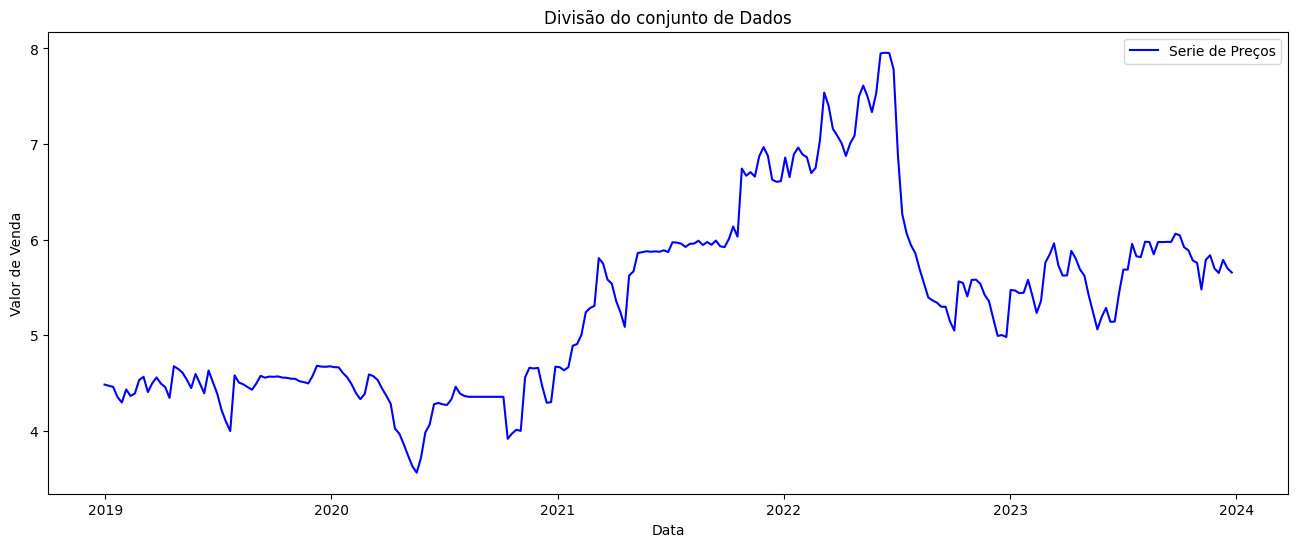

In [6]:
plt.figure(figsize=(16,6))

plt.title("Divisão do conjunto de Dados")

plt.plot(y,label='Serie de Preços', color='blue')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()

# Plota mais uma vez a serie com um ponto a mais  ou em validação ou em treinamento
# colocar linha vertical pra distinguir teste e validação

## Análise de Autocorrelação

<function matplotlib.pyplot.show(close=None, block=None)>

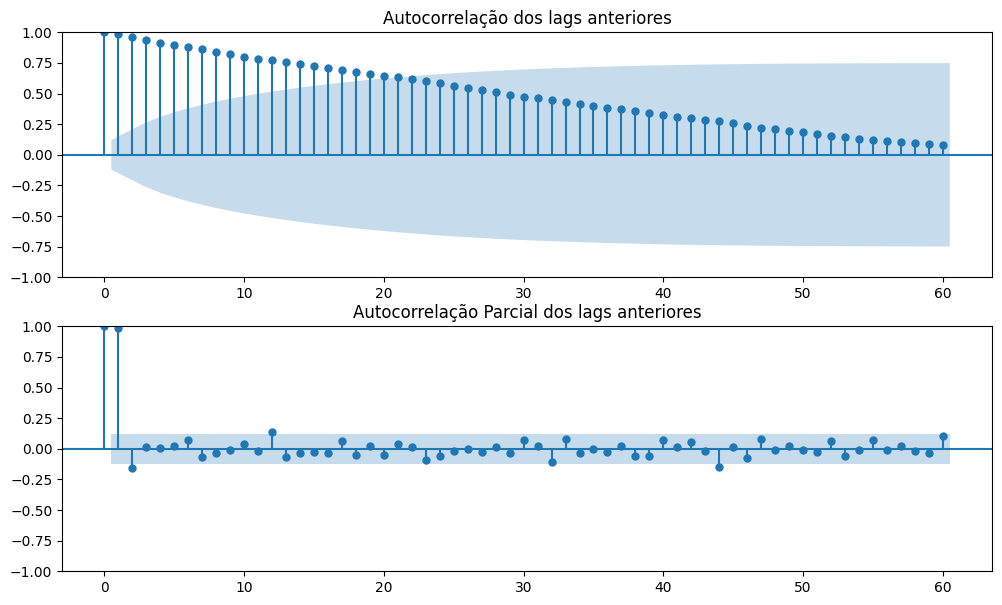

In [7]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(X['Valor de Venda'], lags=60, ax=ax1)
ax1.set_title("Autocorrelação dos lags anteriores")

ax2 = fig.add_subplot(212)
fig = plot_pacf(X['Valor de Venda'], lags=60, ax=ax2)
ax2.set_title("Autocorrelação Parcial dos lags anteriores")

plt.show


Lags Significantes: [1, 2, 12, 23, 30, 32, 33, 34, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60]


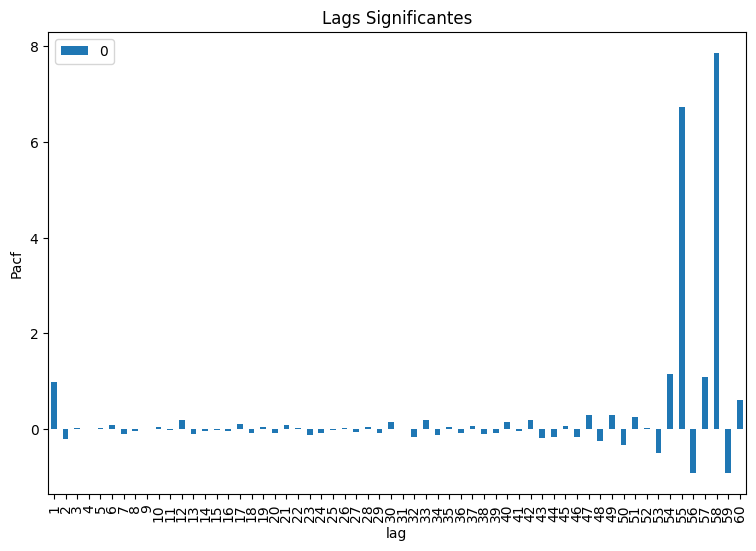

In [8]:
from statsmodels.tsa.stattools import pacf

def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(Pacf)[1:].plot(kind='bar', figsize=(9,6), legend='pacf valores',
                               xlabel='lag', ylabel='Pacf');
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    print('Lags Significantes:', significantLags)
    return significantLags

DT_significantLags = getSignificantLags(dados['Valor de Venda'], nLags = 60, alpha=0.05)
plt.title("Lags Significantes")
plt.show()

## Modelagem

In [9]:
def appendLagVariables(y, significantLags, df, dropna=True, previousData=None):
    prefix = y.replace(')', '')
    df = df.copy()  # Fazendo uma cópia para evitar modificar o original
    x = df[y]

    # Se houver dados anteriores (ex.: dados de treino para preencher lags na validação)
    if previousData is not None:
        x = pd.concat([previousData[y], x])
    
    # Criando as variáveis de lag
    for lag in significantLags:
        varNm = prefix + '-' + str(lag) + ')'
        df[varNm] = x.shift(lag).iloc[len(previousData) if previousData is not None else 0:]
    
    if dropna:
        # Dropar apenas linhas onde os NaN estão nas colunas de lag, preservando a coluna 'Valor de Venda'
        lag_columns = [prefix + '-' + str(lag) + ')' for lag in significantLags]
        df.dropna(subset=lag_columns, inplace=True)
        
    return df


# Usar a função para gerar as variáveis de lag e atribuir ao DataFrame X_train_transformed_df
# Geração das variáveis de lag para o treino
X_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_transformed_df, 
    dropna=True
)

# Separando a variável alvo do treino, validação e teste
y_true = X_transformed_df['Valor de Venda']

# Removendo a coluna de 'Valor de Venda' dos conjuntos de treino, validação e teste
X_transformed_df = X_transformed_df.drop(columns=['Valor de Venda'])


In [10]:

X_transformed_df.head()

,Ano,Mes,Valor de Venda-1),Valor de Venda-2),Valor de Venda-12),Valor de Venda-23),Valor de Venda-30),Valor de Venda-32),Valor de Venda-33),Valor de Venda-34),...,Valor de Venda-50),Valor de Venda-51),Valor de Venda-53),Valor de Venda-54),Valor de Venda-55),Valor de Venda-56),Valor de Venda-57),Valor de Venda-58),Valor de Venda-59),Valor de Venda-60)
Data da Coleta,,,,,,,,,,,,,,,,,,,,,
2020-02-24,2020.0,2.0,4.330369,4.393687,4.573921,4.555368,4.579750,4.095636,4.215864,4.387402,...,4.404784,4.564341,4.390102,4.363602,4.432170,4.295500,4.351458,4.458471,4.470080,4.482750
2020-03-02,2020.0,3.0,4.383542,4.330369,4.679943,4.566177,4.504356,3.996908,4.095636,4.215864,...,4.496281,4.404784,4.530862,4.390102,4.363602,4.432170,4.295500,4.351458,4.458471,4.470080
2020-03-09,2020.0,3.0,4.588957,4.383542,4.671264,4.564253,4.486102,4.579750,3.996908,4.095636,...,4.557663,4.496281,4.564341,4.530862,4.390102,4.363602,4.432170,4.295500,4.351458,4.458471
2020-03-16,2020.0,3.0,4.571135,4.588957,4.669049,4.568286,4.456409,4.504356,4.579750,3.996908,...,4.493517,4.557663,4.404784,4.564341,4.530862,4.390102,4.363602,4.432170,4.295500,4.351458
2020-03-23,2020.0,3.0,4.530878,4.571135,4.674380,4.556703,4.429330,4.486102,4.504356,4.579750,...,4.456494,4.493517,4.496281,4.404784,4.564341,4.530862,4.390102,4.363602,4.432170,4.295500


## Gradient Descendent Online in ridge regression

Previsões de Random Walk para o conjunto de validação:


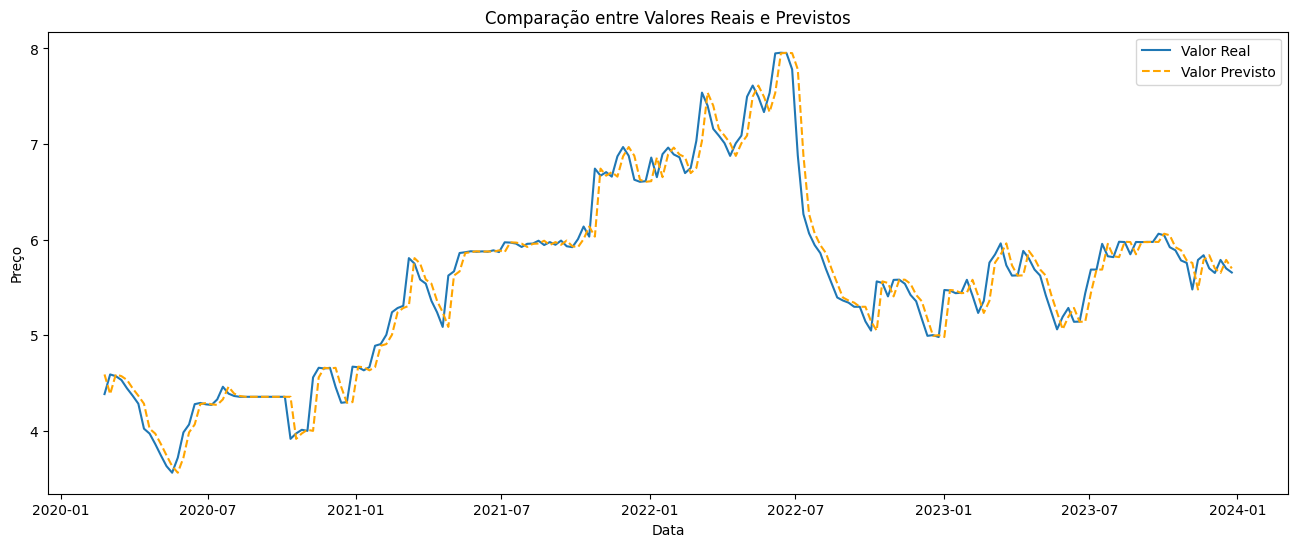

In [11]:
# Combine os dados de treino e validação para formar uma série contínua
X_combined_df = X_transformed_df
y_combined = y_true

# Função de previsão Random Walk para o conjunto de validação
def random_walk_forecast(series):
    # Previsão do Random Walk: a previsão para cada ponto é o valor imediatamente anterior
    return series.shift(1)

# Aplicar a previsão no conjunto combinado
y_forecast = random_walk_forecast(y_true)
y_forecast.iloc[0] = y_true.iloc[1]  # Ajuste o primeiro valor

# Selecionar apenas as previsões para o conjunto de validação
y_forecast = y_forecast.loc[y_true.index]

# Exibir as previsões para o conjunto de validação
print("Previsões de Random Walk para o conjunto de validação:")
plt.figure(figsize=(16, 6))
plt.plot(y_true, label='Valor Real')
plt.plot(y_forecast, label='Valor Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()


In [12]:
computeAccuracyModels(models='Randon Walk', y_pred=y_forecast,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
         model      MAE      MAPE        R2  theil
0  Randon Walk  0.12167  0.021766  0.962998    1.0


In [13]:
from sklearn.preprocessing import StandardScaler

# Calcular resíduos (erro entre a série original e a previsão)
residuos_serie = y_true - y_forecast

# Construir variáveis lagged para previsão
# `X_residual_1` será o resíduo defasado em um ponto
# `X_residual_2` será o resíduo defasado em dois pontos
X_residual_1 = residuos_serie.shift(1)
X_residual_2 = residuos_serie.shift(2)

# Ajustar os valores iniciais ausentes para consistência
X_residual_1.iloc[0] = X_residual_1.iloc[1]  # Ajustar o primeiro valor
X_residual_2.iloc[:2] = X_residual_1.iloc[1]  # Ajustar os dois primeiros valores de X_residual_2

# Concatenar as defasagens em um único DataFrame para escalonamento
X_residual = pd.concat([X_residual_1, X_residual_2], axis=1)
X_residual.columns = ['Lag_1', 'Lag_2']


# Escalar os dados para manter consistência com o modelo anterior
scaler_residual = StandardScaler()
X_residual_scaled = scaler_residual.fit_transform(X_residual.values)

y_residual = residuos_serie.loc[X_residual.index]



In [14]:
X_residual

,Lag_1,Lag_2
Data da Coleta,,
2020-02-24,-0.205415,-0.205415
2020-03-02,-0.205415,-0.205415
2020-03-09,0.205415,-0.205415
2020-03-16,-0.017822,0.205415
2020-03-23,-0.040258,-0.017822
...,...,...
2023-11-27,0.049608,0.309281
2023-12-04,-0.137867,0.049608
2023-12-11,-0.048086,-0.137867


In [15]:
print("residuos forecast",len(y_forecast))
print("residuos",len(y_true))


y_residual_1 = residuos_serie.shift(1)

# Ajustar os valores iniciais ausentes para consistência
y_residual_1.iloc[0] = y_residual_1.iloc[1]  # Ajustar o primeiro valor


residuos forecast 201
residuos 201


In [16]:
print(len(X_residual))
print(len(y_residual))

201
201


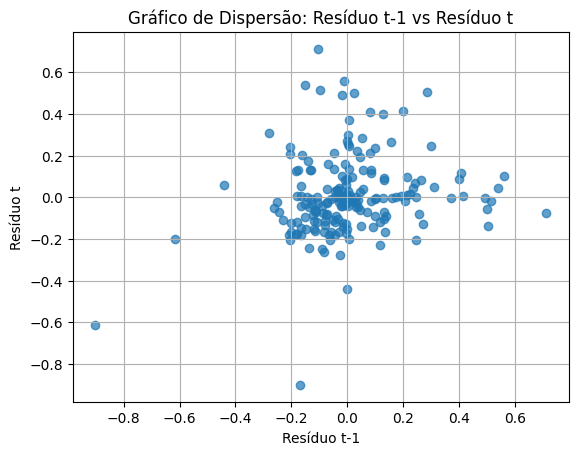

In [17]:
plt.scatter(y_residual_1,y_residual, alpha=0.7)
plt.title("Gráfico de Dispersão: Resíduo t-1 vs Resíduo t")
plt.xlabel("Resíduo t-1")
plt.ylabel("Resíduo t")
plt.grid(True)
plt.show()

# usar regressão linear pra prever os residuos

In [18]:
'''df = pd.DataFrame(
    {
         'valor dos residuos': residuos_serie,
         'residuos com lag(1)':X_residual
    }
)'''

"df = pd.DataFrame(\n    {\n         'valor dos residuos': residuos_serie,\n         'residuos com lag(1)':X_residual\n    }\n)"

In [19]:
'''df.corr()'''

'df.corr()'

c:\Users\kaio\OneDrive\Área de Trabalho\Series Temporais\ridge_sgd_kernel.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  self.X_train_tensor = torch.tensor([x_new], dtype=torch.float32)  # Inicializa o conjunto de treino


Melhores parâmetros: OrderedDict([('c', 0.6899999999999998), ('eta', 0.01529288330456413), ('sigma', 0.5)])
Melhor score: 0.038202818948314614


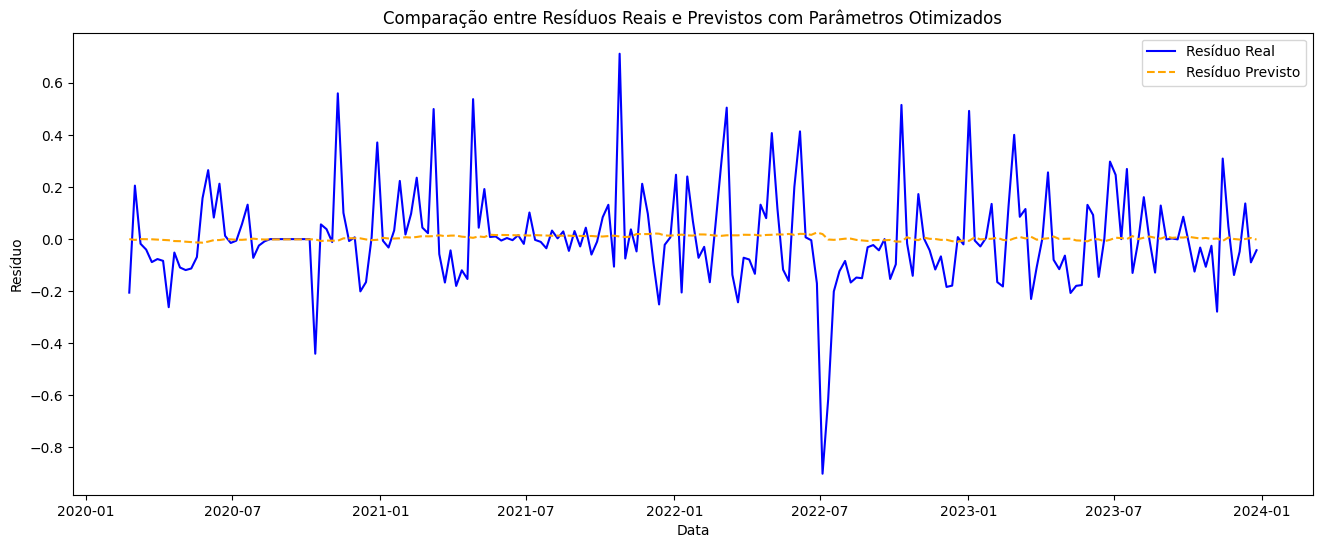

In [20]:

from skopt import BayesSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
from ridge_sgd_kernel import RidgeSGDKernelTorch

# Adaptar a classe para que funcione com BayesSearchCV
class RidgeSGDKernelTorchWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, eta=0.01, c=0.01, sigma=1.0):
        self.eta = eta
        self.c = c
        self.sigma = sigma
        self.model = None

    def fit(self, X, y):
        # Inicializar o modelo
        self.model = RidgeSGDKernelTorch(eta=self.eta, c=self.c, sigma=self.sigma)
        # Treinar online
        for x_new, y_new in zip(X, y):
            self.model.partial_fit(x_new, y_new)
        return self

    def predict(self, X):
        # Realizar previsões
        return np.array([self.model.predict(x) for x in X])

# Definir o espaço de busca dos hiperparâmetros
param_grid = {
    'eta': (0.01, 0.8, 'log-uniform'),
    'c': (0.01,0.69, 'log-uniform'),
    'sigma': (0.5, 1.0, 'uniform')
}


# Implementar o BayesSearchCV
# TimeSeriesSplit é utilizado para manter a sequência temporal durante a validação cruzada
bayes_search = BayesSearchCV(
    RidgeSGDKernelTorchWrapper(),
    search_spaces=param_grid,
    n_iter=30,  # Número de iterações da busca bayesiana
    cv=TimeSeriesSplit(n_splits=3),  # Validação cruzada para séries temporais
    scoring='neg_mean_squared_error',  # Função de perda (erro quadrático médio)
    n_jobs=-1
)

# Realizar a busca
bayes_search.fit(X_residual.values, y_residual.values)

# Exibir os melhores parâmetros encontrados
print("Melhores parâmetros:", bayes_search.best_params_)
print("Melhor score:", -bayes_search.best_score_)


# Obter os melhores parâmetros da busca
best_eta = bayes_search.best_params_['eta']
best_c = bayes_search.best_params_['c']
best_sigma = bayes_search.best_params_['sigma']

# Criar e treinar o modelo com os melhores parâmetros encontrados
ridge_sgd_torch_best = RidgeSGDKernelTorch(eta=best_eta, c=best_c, sigma=best_sigma)

# Lista para armazenar previsões
y_pred_best = []

# Treinar e prever de forma online com os dados residuais
for x_new, y_new in zip(X_residual.values, y_residual.values):
    ridge_sgd_torch_best.partial_fit(x_new, y_new)  # Atualiza o modelo com o novo ponto
    prediction = ridge_sgd_torch_best.predict(x_new)  # Faz a previsão imediatamente após o ajuste
    y_pred_best.append(prediction)

# Previsões indexadas para facilitar o plot
y_pred_bayes_indexed = pd.Series(y_pred_best, index=y_residual.index)

# Visualizar os resultados
plt.figure(figsize=(16, 6))
plt.plot(y_residual, label='Resíduo Real', color='blue')
plt.plot(y_pred_bayes_indexed, label='Resíduo Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Resíduos Reais e Previstos com Parâmetros Otimizados')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.legend()
plt.show()

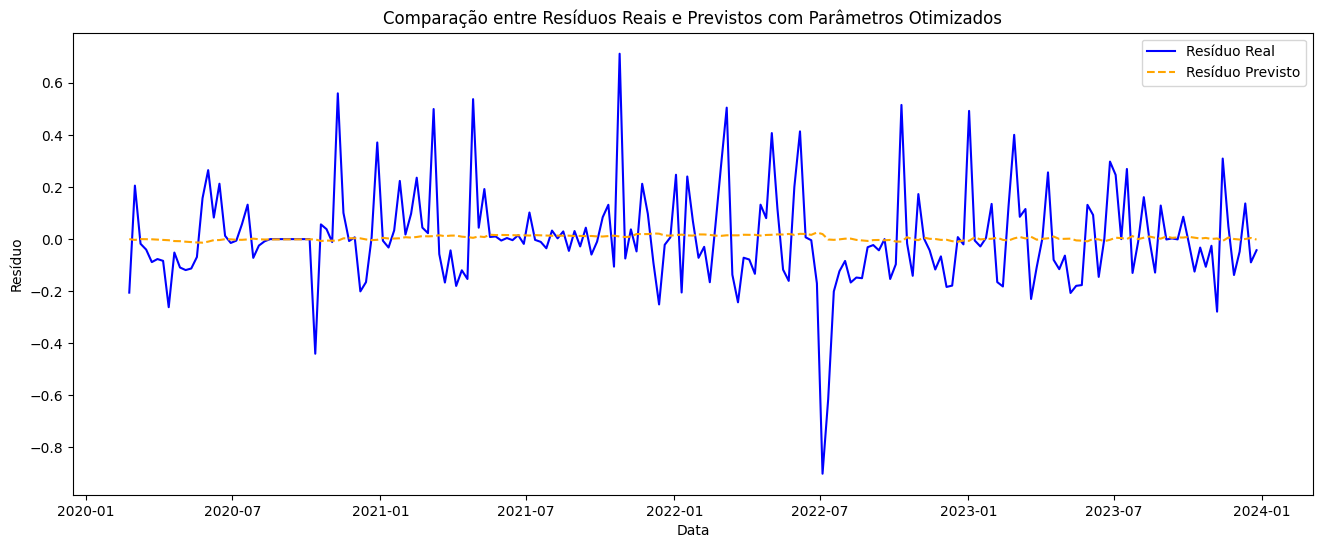

In [21]:

# Obter os melhores parâmetros da busca
best_eta = bayes_search.best_params_['eta']
best_c = bayes_search.best_params_['c']
best_sigma = bayes_search.best_params_['sigma']

# Criar e treinar o modelo com os melhores parâmetros encontrados
ridge_sgd_torch_best = RidgeSGDKernelTorch(eta=best_eta, c=best_c, sigma=best_sigma)

# Lista para armazenar previsões
y_pred_best = []

# Treinar e prever de forma online com os dados residuais
for x_new, y_new in zip(X_residual.values, y_residual.values):
    ridge_sgd_torch_best.partial_fit(x_new, y_new)  # Atualiza o modelo com o novo ponto
    prediction = ridge_sgd_torch_best.predict(x_new)  # Faz a previsão imediatamente após o ajuste
    y_pred_best.append(prediction)

# Previsões indexadas para facilitar o plot
y_pred_bayes_indexed = pd.Series(y_pred_best, index=y_residual.index)

# Visualizar os resultados
plt.figure(figsize=(16, 6))
plt.plot(y_residual, label='Resíduo Real', color='blue')
plt.plot(y_pred_bayes_indexed, label='Resíduo Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Resíduos Reais e Previstos com Parâmetros Otimizados')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.legend()
plt.show()



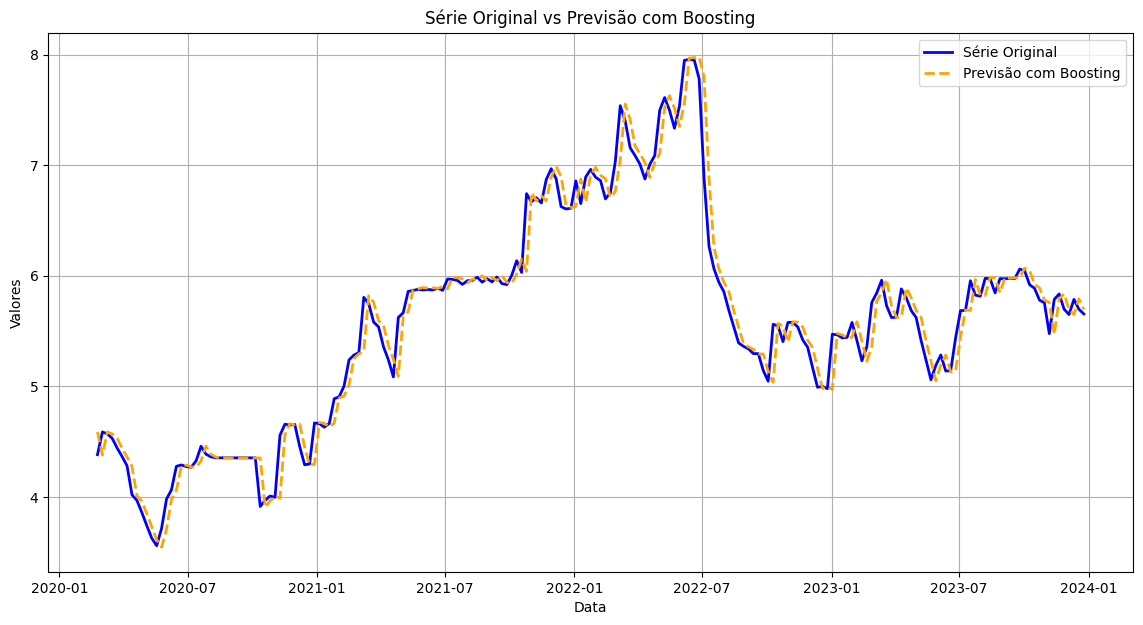

In [22]:
import matplotlib.pyplot as plt

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast_bayes = y_forecast + y_pred_bayes_indexed

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(y_pred_bayes_indexed.index, y_boosted_forecast_bayes, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()


In [23]:

computeAccuracyModels(models='Boosting with bayes-NORMA', y_pred=y_boosted_forecast_bayes,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model      MAE      MAPE        R2     theil
0                Randon Walk  0.12167  0.021766  0.962998  1.000000
1  Boosting with bayes-NORMA  0.12274  0.021931  0.962880  1.003204


Previsões para os resíduos: [0.0, -0.08216612786054611, 0.02251972071826458, 0.009357900358736515, 0.0016526319086551666, -0.02993955835700035, -0.03711266815662384, -0.04483558610081673, -0.09266845881938934, -0.056729938834905624, -0.06874130666255951, -0.0668739303946495, -0.06525393575429916, -0.04868791252374649, 0.0329599566757679, 0.07394897937774658, 0.04360952973365784, 0.10526017099618912, 0.04694000631570816, 0.017909394577145576, 0.004144666716456413, 0.02316959947347641, 0.05379980802536011, -0.004465254954993725, -0.0032349685207009315, -0.00700592715293169, -0.00290040485560894, -0.001116893719881773, -0.00033506471663713455, -0.00010051904246211052, -3.0157621949911118e-05, -9.04756598174572e-06, -2.7138739824295044e-06, -8.142087608575821e-07, -0.05962882563471794, -0.04196064919233322, -0.0893210619688034, -0.029958907514810562, 0.03460799530148506, 0.037732478231191635, 0.13107271492481232, 0.049543172121047974, -0.046725593507289886, -0.06381618231534958, -0.0272273

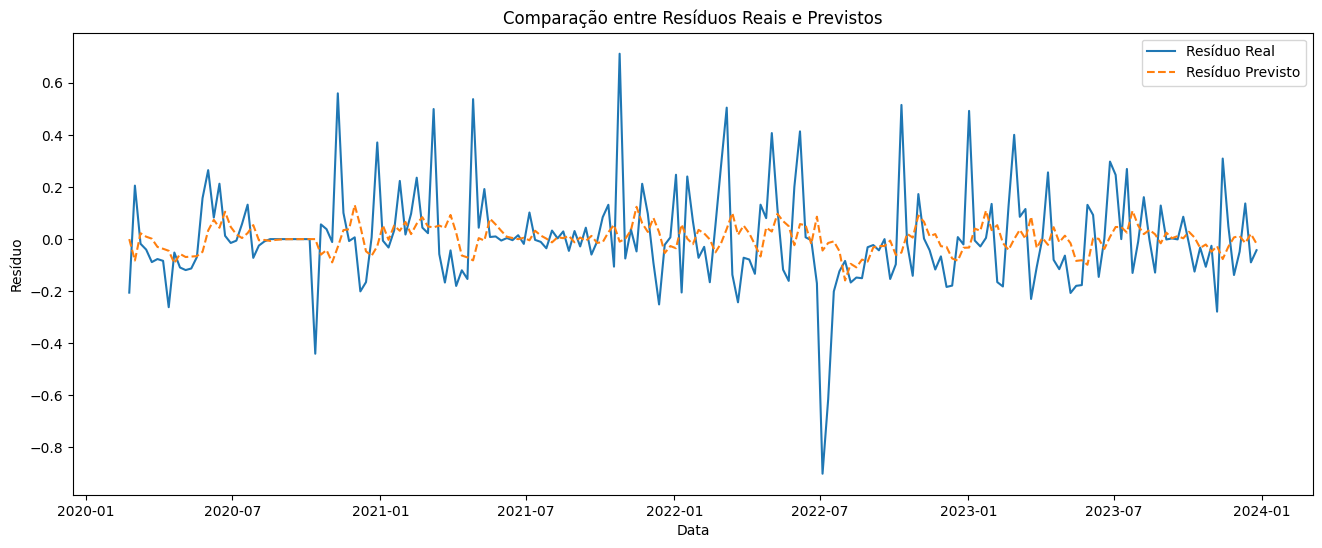

In [24]:
from ridge_sgd_kernel import RidgeSGDKernelTorch, Ridgkernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Criar o modelo para os resíduos
ridge_sgd_torch_residual = RidgeSGDKernelTorch(eta=0.5, c=0.4, sigma=0.3)

# List para armazenar previsões
y_pred_residual = []

# Treinar e prever de forma online com os dados residuais
for x_new, y_new in zip(X_residual.values, y_residual.values):
    ridge_sgd_torch_residual.partial_fit(x_new, y_new)  # Atualiza o modelo com o novo ponto
    prediction = ridge_sgd_torch_residual.predict(x_new)  # Faz a previsão imediatamente após o ajuste
    y_pred_residual.append(prediction)

# Previsões indexadas
y_pred_residual_indexed = pd.Series(y_pred_residual, index=y_residual.index)

# Visualizar os resultados
print("Previsões para os resíduos:", y_pred_residual)
plt.figure(figsize=(16, 6))
plt.plot(y_residual, label='Resíduo Real')
plt.plot(y_pred_residual_indexed, label='Resíduo Previsto', linestyle='--')
plt.title('Comparação entre Resíduos Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.legend()
plt.show()



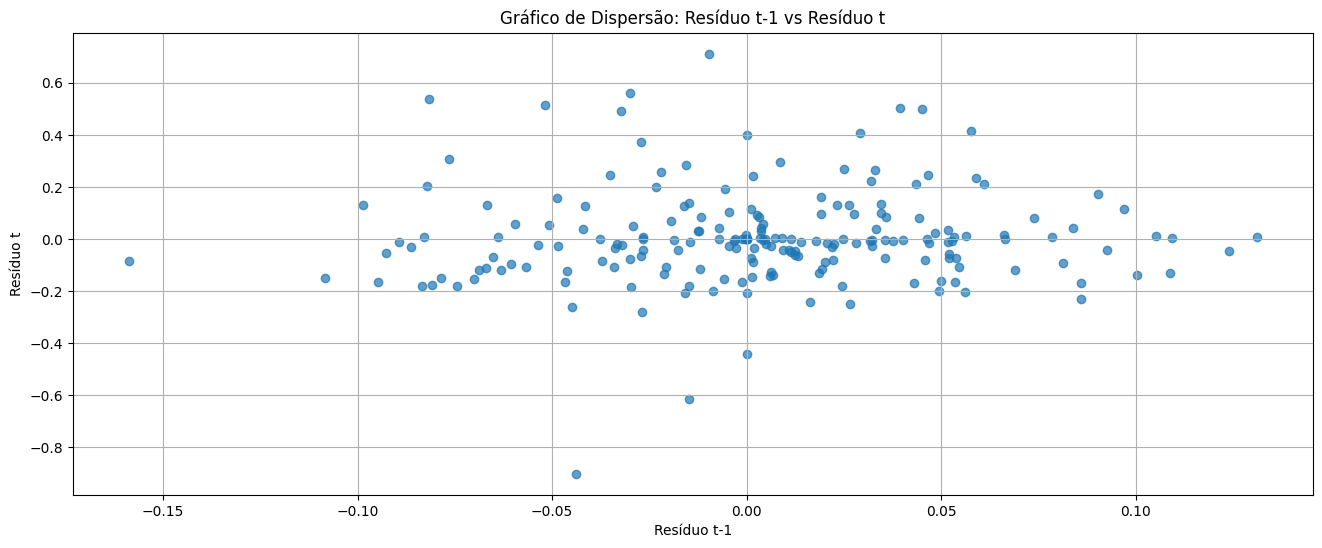

In [25]:
plt.figure(figsize=(16, 6))

plt.scatter(y_pred_residual_indexed,y_residual,alpha=0.7)
plt.title("Gráfico de Dispersão: Resíduo t-1 vs Resíduo t")
plt.xlabel("Resíduo t-1")
plt.ylabel("Resíduo t")
plt.grid(True)
plt.show()

In [26]:
X_residual

,Lag_1,Lag_2
Data da Coleta,,
2020-02-24,-0.205415,-0.205415
2020-03-02,-0.205415,-0.205415
2020-03-09,0.205415,-0.205415
2020-03-16,-0.017822,0.205415
2020-03-23,-0.040258,-0.017822
...,...,...
2023-11-27,0.049608,0.309281
2023-12-04,-0.137867,0.049608
2023-12-11,-0.048086,-0.137867


In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from norm import RidgeSGDKernelTorchDict

# Supondo que seus dados residuais estejam em `y_residual` e `X_residual`
# Converter os dados em dicionários para serem compatíveis com o modelo, utilizando o índice de `y_residual`
X_residual_dict = {idx: x for idx, x in zip(y_residual.index, X_residual.values)}
y_residual_dict = {idx: y for idx, y in zip(y_residual.index, y_residual.values)}

# Instanciar o modelo com os parâmetros desejados
ridge_sgd_torch = RidgeSGDKernelTorchDict(eta=0.1, c=0.1, sigma=1.0)

# Lista para armazenar previsões
y_pred = {}

# Treinar e prever de forma online com os dados residuais
for idx in X_residual_dict.keys():
    x_new = X_residual_dict[idx]
    y_new = y_residual_dict[idx]

    # Atualizar o modelo com o novo ponto
    ridge_sgd_torch.partial_fit(x_new, y_new, idx)

    # Fazer a previsão
    prediction = ridge_sgd_torch.predict(x_new)
    y_pred[idx] = prediction

# Converter as previsões em um pandas.Series para facilitar o plot
y_pred_series = pd.Series(y_pred).sort_index()
y_residual_series = pd.Series(y_residual_dict).sort_index()

# Visualizar os resultados
plt.figure(figsize=(16, 6))
plt.plot(y_residual_series, label='Resíduo Real', color='blue')
plt.plot(y_pred_series, label='Resíduo Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Resíduos Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.legend()
plt.show()



AttributeError: 'RidgeSGDKernelTorchDict' object has no attribute 'predict'

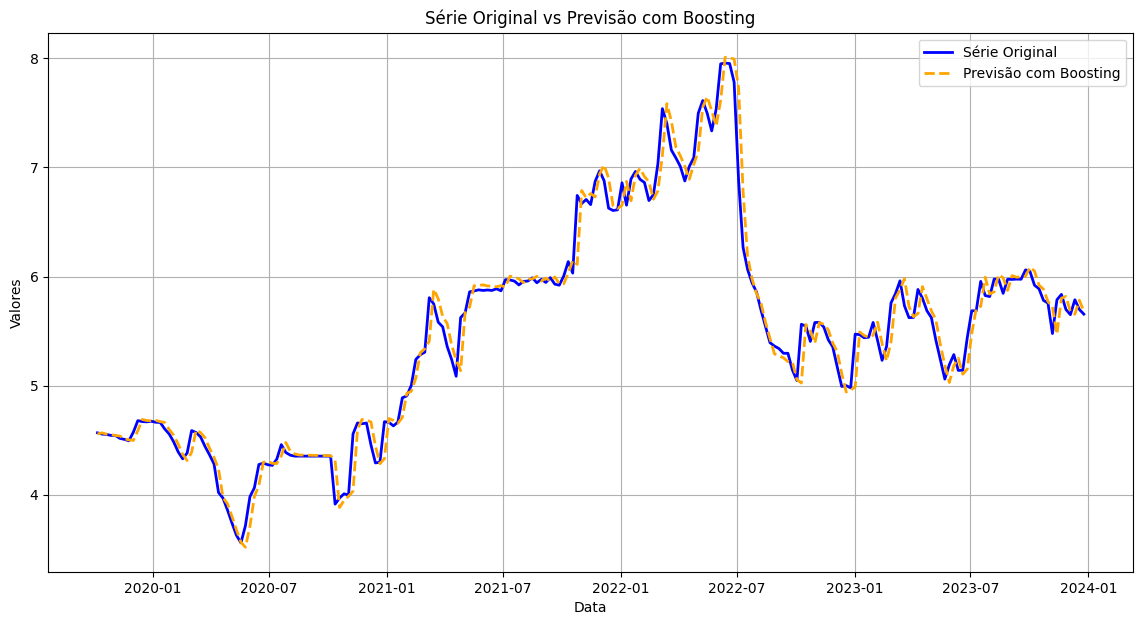

In [ ]:
# Combine as previsões
y_boosted_forecast_norm_dict = y_forecast + y_pred_series

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(y_pred_series.index, y_boosted_forecast_norm_dict, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:

computeAccuracyModels(models='Boosting with NORM-DICT', y_pred=y_boosted_forecast_norm_dict,y_true=y_true)


 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model       MAE      MAPE        R2     theil
2    Boosting with NORM-DICT  0.105454  0.018859  0.971811  0.839126
1  Boosting with bayes-NORMA  0.110929  0.019862  0.967702  0.961447
0                Randon Walk  0.112817  0.020268  0.966407  1.000000


## Arima 

In [ ]:
X_residual = X_residual.drop(columns='Lag_2')

In [ ]:
X_residual

,Lag_1
Data da Coleta,
2019-10-07,0.011582
2019-10-14,0.011582
2019-10-21,-0.011582
2019-10-28,-0.003001
2019-11-04,-0.009220
...,...
2023-11-27,0.049608
2023-12-04,-0.137867
2023-12-11,-0.048086


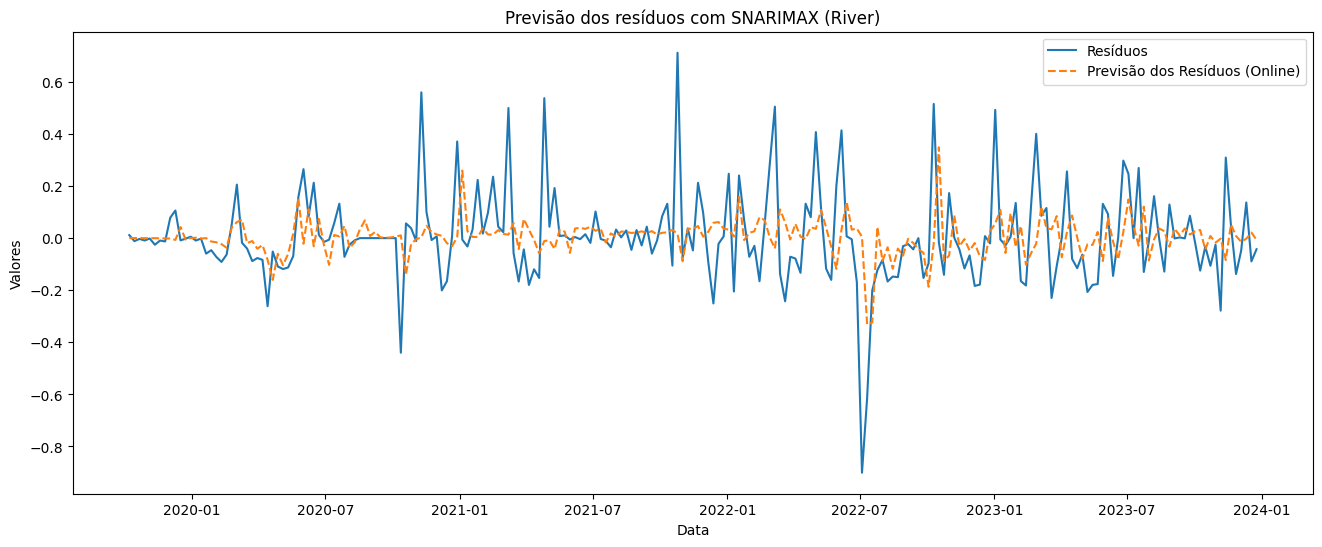

In [ ]:
from river.time_series import SNARIMAX
import pandas as pd
import matplotlib.pyplot as plt

# Inicializar o modelo SNARIMAX
model = SNARIMAX(
    p=1, d=0, q=1, 
    m=12,  # Ajuste a sazonalidade conforme necessário (ex.: 12 para sazonalidade anual em dados mensais)
    sp=1, sd=0, sq=1
)

# Lista para armazenar as previsões iterativas
predictions_online = []

# Prever um ponto de cada vez e atualizar o modelo
for i in range(len(y_residual)):
    # Obter o valor real atual
    real_value = y_residual.iloc[i]
    
    # Fazer a previsão com o modelo (horizon=1 para prever um ponto)
    prediction = model.forecast(horizon=1)
    
    # Armazenar a previsão
    predictions_online.append(prediction[0])  # Como forecast retorna uma lista, pegamos o primeiro valor
    
    # Atualizar o modelo com a observação real
    model.learn_one(real_value)

# Convertendo as previsões para uma série
prediction_series_online = pd.Series(predictions_online, index=y_residual.index)

# Plotar os resultados
plt.figure(figsize=(16, 6))
plt.plot(y_residual.index, y_residual, label='Resíduos')
plt.plot(prediction_series_online.index, prediction_series_online, label='Previsão dos Resíduos (Online)', linestyle='--')
plt.title('Previsão dos resíduos com SNARIMAX (River)')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()




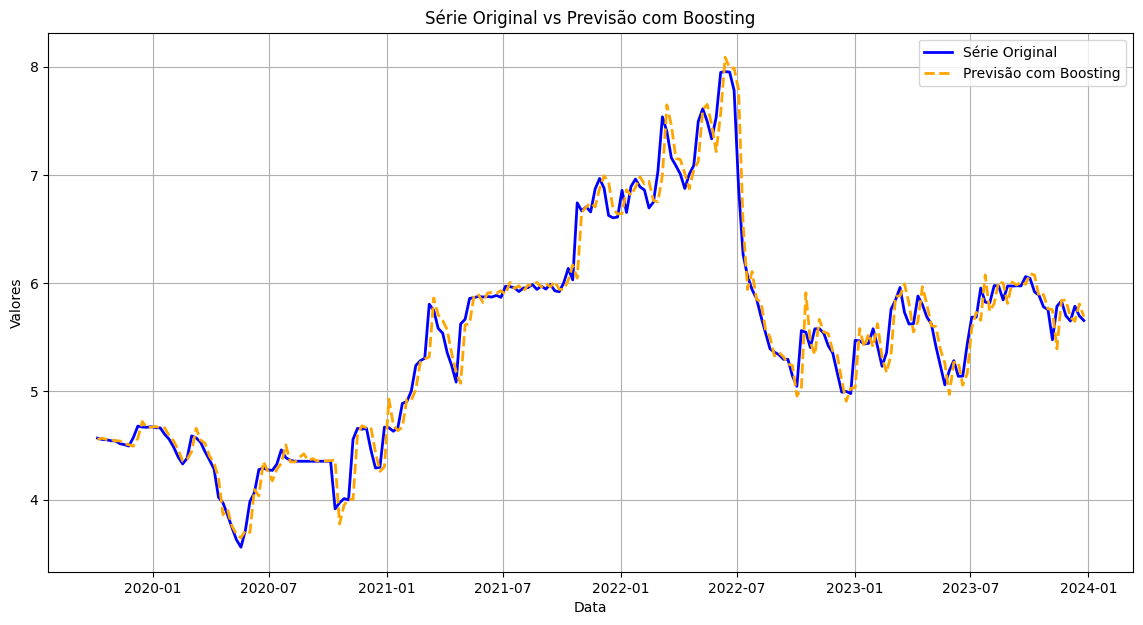

In [ ]:

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast_arima = y_forecast + prediction_series_online

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(prediction_series_online.index, y_boosted_forecast_arima, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
computeAccuracyModels(models='Boosting with Arima', y_pred=y_boosted_forecast_arima,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model       MAE      MAPE        R2     theil
2    Boosting with NORM-DICT  0.105454  0.018859  0.971811  0.839126
1  Boosting with bayes-NORMA  0.110929  0.019862  0.967702  0.961447
0                Randon Walk  0.112817  0.020268  0.966407  1.000000
3        Boosting with Arima  0.118068  0.021119  0.965759  1.019289


## Regressão Linear River

Média Absoluta do Erro (MAE): 0.11426942588455193
Data da Coleta
2019-10-07    0.000000
2019-10-14    0.000232
2019-10-21   -0.000005
2019-10-28   -0.000065
2019-11-04   -0.000248
                ...   
2023-11-27    0.001276
2023-12-04   -0.001507
2023-12-11   -0.002439
2023-12-18    0.000347
2023-12-25   -0.001445
Length: 221, dtype: float64


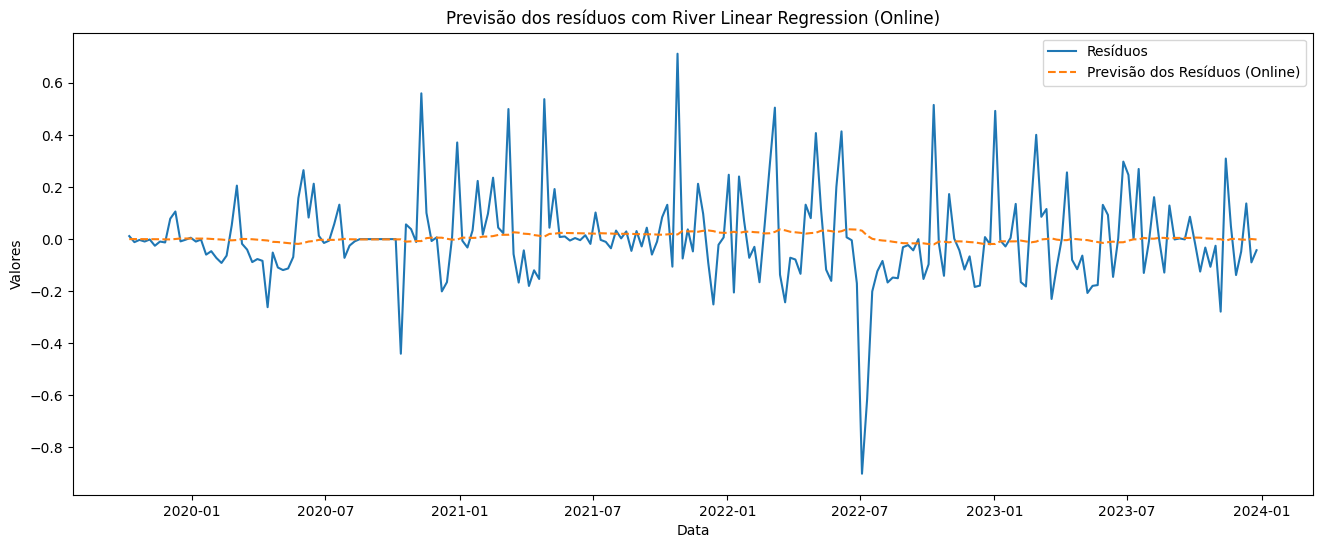

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from river import linear_model, metrics
from river import preprocessing

# Exemplo: Supondo que y_residual seja um DataFrame com um índice de tempo e duas colunas
# 'Lag_1' (feature) e 'Residual' (target)
# Certifique-se de ajustar esses nomes para o seu dataset real
data = pd.DataFrame({'Lag_1': X_residual['Lag_1'], 'Residual': y_residual})

# Modelo de regressão linear online do river
model = linear_model.LinearRegression()

# Normalizador online para manter os dados na mesma escala
scaler = preprocessing.StandardScaler()

# Métrica para avaliar o modelo
metric = metrics.MAE()

# Lista para armazenar as previsões
predictions_online = []

# Iteração online nos dados
for index, row in data.iterrows():
    x = {'Lag_1': row['Lag_1']}  # Feature
    y = row['Residual']          # Target

    # Fazer a previsão antes da atualização do modelo
    y_pred = model.predict_one(scaler.transform_one(x))
    predictions_online.append(y_pred)

    # Atualizar o modelo e o normalizador com os dados reais
    x_scaled = scaler.learn_one(x)
    model.learn_one(x_scaled, y)

    # Atualizar a métrica
    if y_pred is not None:
        metric.update(y, y_pred)

# Converter previsões para uma série para facilitar a análise
prediction_series_online = pd.Series(predictions_online, index=data.index)

print(f"Média Absoluta do Erro (MAE): {metric.get()}")
print(prediction_series_online)

# Plotar os resultados
plt.figure(figsize=(16, 6))
plt.plot(data.index, data['Residual'], label='Resíduos')
plt.plot(prediction_series_online.index, prediction_series_online, label='Previsão dos Resíduos (Online)', linestyle='--')
plt.title('Previsão dos resíduos com River Linear Regression (Online)')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()


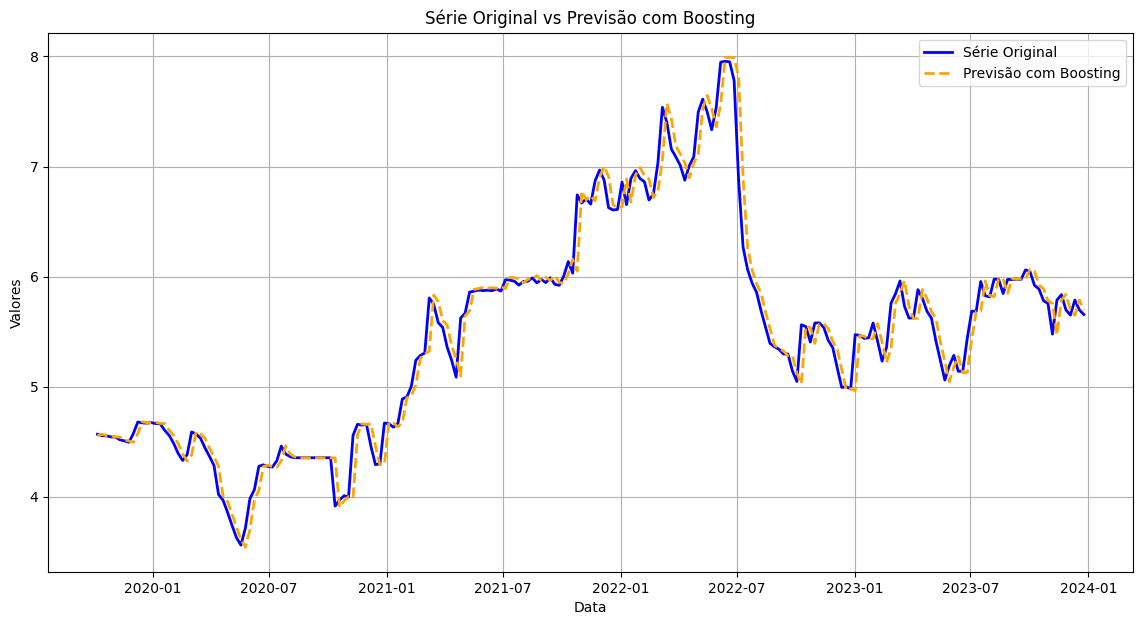

In [ ]:

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast_RL = y_forecast + prediction_series_online

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(prediction_series_online.index, y_boosted_forecast_RL, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
computeAccuracyModels(models='Boosting with RL River', y_pred=y_boosted_forecast_RL,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model       MAE      MAPE        R2     theil
2    Boosting with NORM-DICT  0.105454  0.018859  0.971811  0.839126
1  Boosting with bayes-NORMA  0.110929  0.019862  0.967702  0.961447
0                Randon Walk  0.112817  0.020268  0.966407  1.000000
4     Boosting with RL River  0.114269  0.020478  0.965994  1.012287
3        Boosting with Arima  0.118068  0.021119  0.965759  1.019289


## Holt Winters

Média Absoluta do Erro (MAE): 0.13718586229000893
Data da Coleta
2019-10-07    0.000000
2019-10-14    0.000000
2019-10-21   -0.023165
2019-10-28   -0.039675
2019-11-04   -0.052185
                ...   
2023-11-27    0.014320
2023-12-04   -0.033924
2023-12-11   -0.041186
2023-12-18    0.014560
2023-12-25   -0.017370
Length: 221, dtype: float64


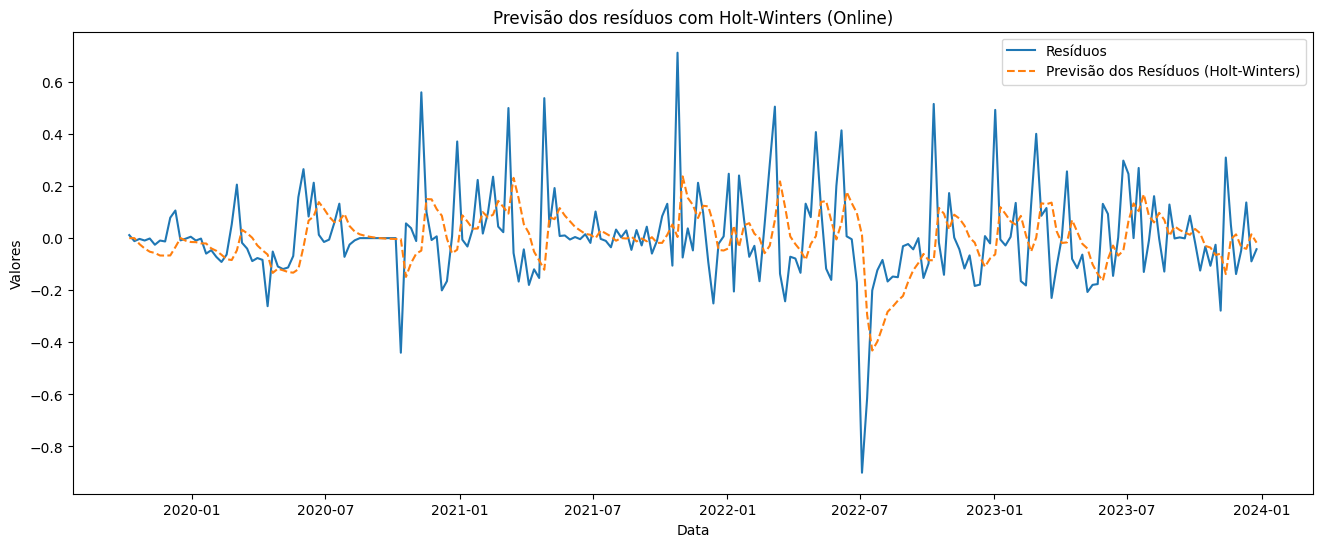

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from river import time_series, metrics

# Exemplo: Supondo que y_residual seja um DataFrame com um índice de tempo e a coluna 'Residual'
# Certifique-se de ajustar esses nomes para o seu dataset real
data = pd.DataFrame({'Residual': y_residual})

# Modelo Holt-Winters online (suavização exponencial com nível e tendência)
model = time_series.HoltWinters(alpha=0.3, beta=0.1, gamma=0.0)  # gamma=0.0 para desativar sazonalidade

# Métrica para avaliar o modelo
metric = metrics.MAE()

# Lista para armazenar as previsões
predictions_online = []

# Iteração online nos dados
for index, row in data.iterrows():
    y = row['Residual']  # Valor real do resíduo
    
    # Fazer a previsão somente após inicializar o modelo
    if len(model.level) > 0:  # Verifica se o nível foi inicializado
        y_pred = model.forecast(horizon=1)[0]
    else:
        y_pred = None  # Sem previsão inicial
    
    predictions_online.append(y_pred if y_pred is not None else 0)  # Atribui 0 se não houver previsão
    
    # Atualizar o modelo com o valor real
    model.learn_one(y)
    
    # Atualizar a métrica
    if y_pred is not None:
        metric.update(y, y_pred)

# Converter previsões para uma série para facilitar a análise
prediction_series_online = pd.Series(predictions_online, index=data.index)

print(f"Média Absoluta do Erro (MAE): {metric.get()}")
print(prediction_series_online)

# Plotar os resultados
plt.figure(figsize=(16, 6))
plt.plot(data.index, data['Residual'], label='Resíduos')
plt.plot(prediction_series_online.index, prediction_series_online, label='Previsão dos Resíduos (Holt-Winters)', linestyle='--')
plt.title('Previsão dos resíduos com Holt-Winters (Online)')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()



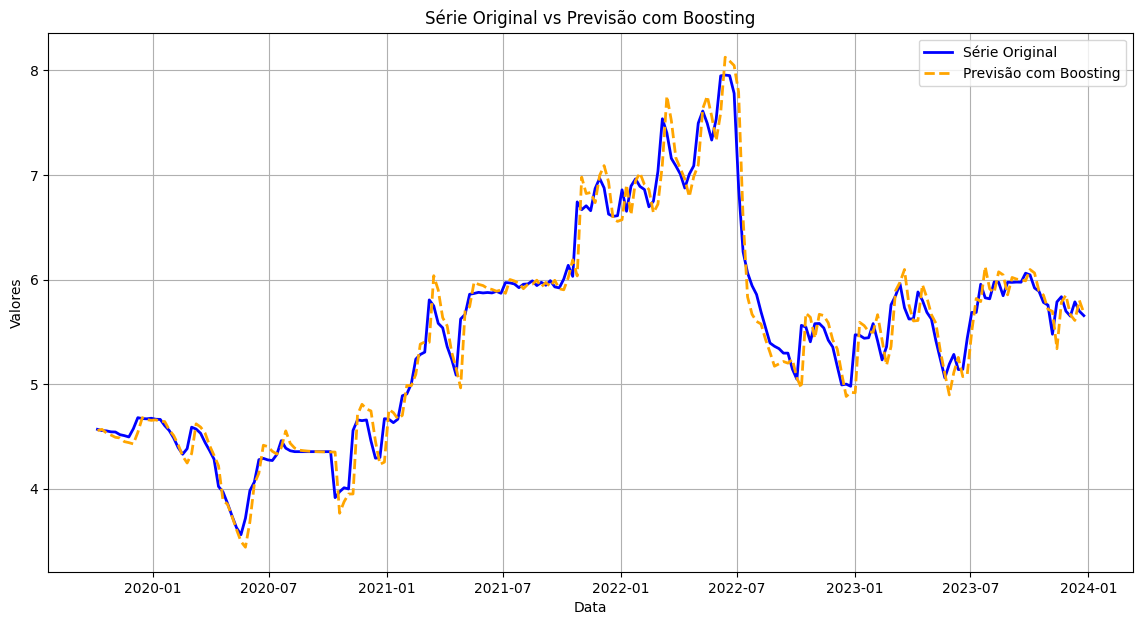

In [ ]:

# Supondo que `y_original` seja sua série original para comparar com a previsão ajustada
# Combine as previsões
y_boosted_forecast_HW = y_forecast + prediction_series_online

# Plotando a série original e a previsão ajustada com boosting
plt.figure(figsize=(14, 7))

# Plot da série original
plt.plot(y_true.index, y_true, label='Série Original', color='blue', linewidth=2)

# Plot da previsão com boosting
plt.plot(prediction_series_online.index, y_boosted_forecast_HW, label='Previsão com Boosting', color='orange', linestyle='--', linewidth=2)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Série Original vs Previsão com Boosting')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
computeAccuracyModels(models='Boosting with HW River', y_pred=y_boosted_forecast_HW,y_true=y_true)

 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                       model       MAE      MAPE        R2     theil
2    Boosting with NORM-DICT  0.105454  0.018859  0.971811  0.839126
1  Boosting with bayes-NORMA  0.110929  0.019862  0.967702  0.961447
0                Randon Walk  0.112817  0.020268  0.966407  1.000000
4     Boosting with RL River  0.114269  0.020478  0.965994  1.012287
3        Boosting with Arima  0.118068  0.021119  0.965759  1.019289
5     Boosting with HW River  0.136049  0.024348  0.959292  1.211804
